# Multivariate Analysis
In this notebook we will perform a supervised *multivariate* Partial least-sqare --  discriminant analysis (PLS-DA) of the [AddNeuroMed](https://nyaspubs.onlinelibrary.wiley.com/doi/10.1111/j.1749-6632.2009.05064.x) dataset of Alzheimer's disease. It is recommended to finish first the notebook *Multivariate Analysis - PCA*.
<br>
This is LC-MS based version of the tutorial, for NMR version please visit the course [GitHub Repository](https://github.com/orgs/IPTC-DataAnalysisCourse/repositories) or run it in Google Colab [notebook](https://colab.research.google.com/drive/1ioNfhdnZ1p8o_MYQ_5exp5mjxWg62bZX).

The notebook is divided in the following steps:

1) **Model Fitting Basics:** Fit PLS-DA models to predict sex from the metabolic profile data, using different types of scaling, and introduction of different types of evaluation.

2) **Model Selection:** Describe model cross-validation, estimation of latent variables (LV), parameter selection and performance assessment, including permutation testing.

3) **Model interpretation:** Describe some of the available variable importance metrics for PLS-DA, and highlight which variables might be important for the discrimination and use of permutation testing.

4) **A brief introduction to Orthogonal PLS (OPLS) modelling:** Compare results of PLS-DA and OPLS-DA

<br>

*Credits: This tutorial was originally created by Gonçalo Correia and was adapted by Lukas Kopecky and Frederico Soares in November 2023*

*Updated by Lukas Kopecky in June 2025.*


## Preliminary Steps

### Installing Packages

First we need to install required packages and clone the files from the [GitHub Rpository](https://github.com/kopeckylukas/IPTC-chemometrics-tutorials-LCMS.git) using this we will use some BASH scripting. You can skip this step if you are running this tutorial locally on your system; we recommend you to use Anaconda to install the required packages instead and then clone the files from GitHub repository locally.

In [1]:
!pip install -q ipympl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.4 MB/s eta 0:00:00


In [2]:
!pip install kneed

In [2]:
!git clone https://github.com/kopeckylukas/IPTC-chemometrics-tutorials-LCMS.git
%cd IPTC-chemometrics-tutorials-LCMS

fatal: destination path 'IPTC-chemometrics-tutorials-LCMS' already exists and is not an empty directory.
/content/IPTC-chemometrics-tutorials-LCMS


### Import Packages

Import all the required Python packages including pyChemometrics model objects.

In [1]:
!pip install scipy==1.11.3 numpy==1.26.4

import scipy
import numpy as np

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from pyChemometrics.ChemometricsPLSDA import ChemometricsPLSDA
from pyChemometrics.ChemometricsScaler import ChemometricsScaler
from pyChemometrics.ChemometricsOrthogonalPLSDA import ChemometricsOrthogonalPLSDA
from pyChemometrics.plotting_utils import _scatterplots

# Set seed to ensure reproducibility of results
np.random.seed(350)

In [4]:
# Set the data conversion warnings to appear only once to avoid repetition during CV
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

The next cell sets up the figure display mode. The *notebook* mode allows interactive plotting.
However, it prolongs the time to render the plots, and it is **NOT RECOMMENDED IN CLOAB**

In [ ]:
# Set the plot backend to support interactive plotting - it prolongs the time to render the plots, NOT RECOMMENDED IN CLOAB
# %matplotlib notebook

### Data Import and Basic Processing

We will now import the LC-MS data with the metadata (Y variables) and feature annotation for LC-MS.

Then we split the data into two parts:

**rpos_x_matrix** - LC-MS data matrix

**gender_y** - Metadata that will act as the response variable for the PLS-DA model (sex/gender in this instance)

Then we extract the feature annotations:

**retention_times**, **mz_values** - annotation for the features of the rpos_x_matrix data

<br>

*NB - The dataset used in this tutorial has reduced features to speed up the model fitting proces. Full data available from [https://zenodo.org/doi/10.5281/zenodo.4053166](https://zenodo.org/doi/10.5281/zenodo.4053166). We recommend you to try to run the tutorial with the full dataset in your own time, or you can even try to run it using your own data.*

In [5]:
# Load the dataset
dementia_rpos_dataset = pd.read_csv("./data/Dementia U RPOS_combinedData.csv",delimiter=',')

# Inspect the dataset
dementia_rpos_dataset.head(10)

,Sample ID,Subject ID,SampleType,Age,Gender,50.3_72.0806m/z,215.75_77.0383m/z,47.38_80.0493m/z,133.09_81.0331m/z,45.8_81.0445m/z,...,221.5_1071.3596m/z,205.8_1073.9622m/z,205.79_1074.4635m/z,205.8_1074.9644m/z,89.98_1083.0771m/z,89.91_1089.0929m/z,333.45_1127.4218m/z,187.72_1153.8814m/z,283.65_1167.5044m/z,74.63_1175.3683m/z
0,LND.0063_U,LND.0063,Study Sample,82.0,Female,4279.391329,132812.07700,4506.074689,2720.562045,2868.745303,...,4085.265210,6732.657513,6347.939155,3902.831649,5798.323898,7964.330802,4796.908684,2165.982590,3846.940012,7223.434421
1,DCR00076_U,DCR00076,Study Sample,74.0,Male,3945.457625,138417.13090,1309.942294,1249.494055,3494.259023,...,11689.675430,5598.134302,5787.515322,3195.600251,5593.213256,7127.606038,217.280582,5715.565758,2685.038347,14887.697220
2,KPOA0004_U,KPOA0004,Study Sample,67.0,Female,9362.587006,142398.08450,18505.468440,9877.856453,1190.134653,...,8113.116987,11536.424940,14606.669620,8306.750990,9581.929077,12591.520030,10220.392560,7290.037248,15899.085500,7111.481525
3,DCR00265_U,DCR00265,Study Sample,88.0,Female,4728.639671,87022.61809,5095.729830,847.960283,1266.689112,...,554.468858,5788.639874,5788.965883,3821.990772,997.141966,2950.769791,2174.997429,925.601299,1696.691802,3536.644549
4,KPOA0049_U,KPOA0049,Study Sample,85.0,Male,8448.154954,185732.46750,4036.783755,14654.424660,6360.068832,...,25373.816680,23308.826020,24329.813490,14261.064530,10243.987800,9933.765569,119.693782,6935.052278,9301.116601,15081.717310
5,KPOA0011_U,KPOA0011,Study Sample,82.0,Male,8333.437153,158113.97740,2927.022002,8535.293454,3462.878918,...,19016.873060,15987.007250,16609.021980,9836.509310,6799.758780,11672.230070,3920.531258,7231.692635,11555.081630,25438.725010
6,PRGM0042_U,PRGM0042,Study Sample,77.0,Male,3551.019694,82850.57009,2528.345643,206.912705,805.523511,...,98.747815,2239.134433,2630.167785,1014.218767,377.620351,1177.499780,0.000000,1054.639825,598.077077,1613.640069
7,LDZM0019_U,LDZM0019,Study Sample,69.0,Female,4156.050266,112126.17020,2659.404458,10544.900410,2386.309049,...,3023.892963,3521.890101,4089.724227,3037.316942,9358.043631,7476.169739,0.000000,1974.148433,1924.622499,5064.162185
8,Study Pool Sample,NaN,Study Pool,NaN,NaN,4841.697700,134620.75260,5101.091535,6291.826442,3722.901385,...,16108.271080,11961.562210,12934.237030,7598.929570,9412.778118,10638.920610,10210.410720,5344.809529,7409.380886,16539.872020
9,KPOA0034_U,KPOA0034,Study Sample,79.0,Male,9405.683884,141447.98940,4041.763242,3193.125809,1738.023817,...,8131.658752,16325.538920,16880.153110,9365.095716,2951.997812,5534.942925,422.108513,2247.097761,7448.401687,10513.124410


#### Data Filtering

In [6]:
# Delete samples where outcome variable is unknown (In this example QC samples)
dementia_rpos_dataset = dementia_rpos_dataset[~dementia_rpos_dataset['Gender'].isnull()]

# Split the data into X and Y
x_data = dementia_rpos_dataset.iloc[:, 5::].values

# Obtain the variable names (m/z and retention time)
variable_names = dementia_rpos_dataset.columns[ 5::]

# Use pandas Categorical type
gender_y = pd.Categorical(dementia_rpos_dataset['Gender']).codes

# Extract the retention times and m/z to use in 2D plots of the dataset
retention_times = np.array([x.split('_')[0] for x in variable_names], dtype='float')/60
mz_values = np.array([x.split('_')[1][0:-3] for x in variable_names], dtype='float')

**Note**: To apply the analyses exemplified in this notebook to any other dataset, just modify the cells above to import the data matrices and vectors X and Y from any other source file. You can also use these methods for analysis of NMR data, adapted version for NMR data is available at the course's repository [GitHub Repository](https://github.com/orgs/IPTC-DataAnalysisCourse/repositories).

The expected data types and formatting for **X** and **Y** are:

   **X**: Any data matrix with n rows (observations/samples) and p columns (variables/features). The matrix should be provided as a [numpy.ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) object, with 2 dimensions, and with shape = (n, p). We recommend using the *numpy* function [numpy.genfromtxt](https://numpy.org/devdocs/reference/generated/numpy.genfromtxt.html) or the *pandas* [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function to read the data from a text file. When using the *pandas.read_csv* function, extract the data matrix as a *numpy.ndarray* from the pandas.DataFrame object using the `.values` attribute.
```
X_DataFrame = pd.read_csv("./data/X_spectra.csv")
X = X_DataFrame.values
```
   
   **Y** vectors: Each **Y** vector should be a 1-dimensional [numpy.ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) object, with a number and ordering of elements matching the rows in **X**. For continuous variables, any regular *numpy.ndarray* with a data type of `int` (integers only) or `float` can be used.
   ```
   Y_continuous = numpy.ndarray([23.4, 24, 0.3, -1.23], dtype='float')
   ```
To encode binary class labels, a *numpy.ndarray* of dtype `int`, with 0 and 1 as labels (e.g., 0 = Control, 1 = Case) must be used. The way in which classes are encoded will affect the model interpretation: the class labeled as 1 is used as the "positive/case" class by the *pyChemometrics* objects.
   
   In the example above, we used the *pandas* [Categorical](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) datatype to handle the conversion of the original numerical values (1, 2) to the required (0, 1) labels. After converting a column to a `Categorical` datatype, the `.codes` attribute returns a vector with the same length of the original Y, but where each value is replaced by their integer (`int`) code. The correspondence between code and category can be inspected with the `categories` attribute. The order of the labels in `.codes` is the same as the order of the `categories` attribute (i.e. 0 is the first element in `categories`, 1 the second and so on).
   ```
   Y1 = pd.Categorical(Y.iloc[:, 1])
   Y1.codes # The numerical label
   Y1.categories # Original text or numerical description of the category
   ```
   [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) is another helpful function to perform dummy (0-1) encoding of variables.

In [7]:
# Compare binary response to labels
print(dementia_rpos_dataset['Gender'].value_counts())
print(pd.DataFrame(gender_y).value_counts())

Gender
Female    294
Male      283
Name: count, dtype: int64
0
0    294
1    283
Name: count, dtype: int64


Plot the log intensities of the features in the dataset. Each point in the scatterplot represents a feature (m/z and retention time combination) and the color represents the log intensity of that feature in the sample.


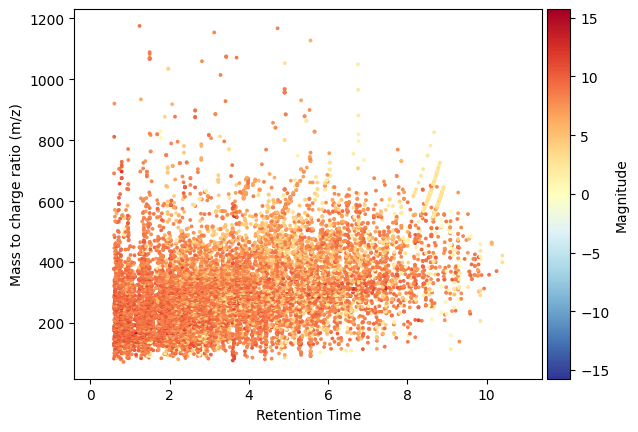

In [8]:
# Plot the spectra in the dataset
_scatterplots(np.log1p(x_data).mean(axis=0), xaxis=retention_times, yaxis=mz_values, marker_size=3, alpha=1)

#### Train -- Test split
Split the dataset to training and testing subsets. The training subset will be used to fit the model, cross-validation and estimation of the number of latent variables. Then the testing subset will be used as an independent dataset to assess the performance of the model. This will ensure that the model is not over-fitted to the data and that in can predict the outcome of the samples.
A common data science practice is to use 70% -- 90% for training and the rest for testing. You should use appropriate split that is working for your data -- both classes should be represented in both subsets in similar proportions.

In [9]:
# Split data into train - test subsets
X_train, X_test, y_train, y_test = train_test_split(x_data, gender_y, test_size=0.10, random_state=42)

In [10]:
print('Samples in the train set: ',X_train.shape[0])

Samples in the train set:  519


In [11]:
print('Samples in the test set: ',X_test.shape[0])

Samples in the test set:  58


## 1) Model Fitting Basics

In this section we will fit a PLS-DA model to classify sex of *AddNeuroMed* Alzheimer's disease patients based on their metabolic profile.

As an example, we start by fitting a PLS-DA model with 2 components and with log transformation and mean centring (MC). The choice of components to use in the modeling will be addressed properly in the next section, the objective of this first section is to introduce the model syntax.

Similar to PCA, we start by choosing a scaling method for the X data matrix. The choice of scaling method will influence the results and interpretation.

### Data Scaling

In [12]:
# Select the scaling options:

# Unit-Variance (UV) scaling:
scaling_object_uv = ChemometricsScaler(scale_power=1)

# Pareto scaling:
scaling_object_par = ChemometricsScaler(scale_power=1/2)

# Mean Centring:
scaling_object_mc = ChemometricsScaler(scale_power=0)

# Reminder: the scale power is the exponent used to scale the standard deviation of the samples in the calculation.

For this example we will use Log(x+1) transformation and Mean Centring, start by fitting a PLS-DA model with 2 components. Feel free to explore other types of scaling (*N.B. Do not run different types of scaler in the live tutorial as this would require re-run of permutation testing*)

In [13]:
# Log scale the data
x_train_log = np.log1p(X_train)
x_test_log = np.log1p(X_test)

### Fitting First Model

In [14]:
# Create and fit PLS-DA model
pls_da = ChemometricsPLSDA(n_components=2, x_scaler=scaling_object_mc)
pls_da.fit(x_train_log, y_train)

PLS models perform dimensionality reduction in a manner similar to PCA. The main difference (besides the criteria in which the components are found) is that as well as the projections for the X matrix ($T$ scores) we also have projections for the Y matrix ($U$ scores).

Model visualisation of PLS/PLS-DA models is typically performed by plotting the $T$ scores (X matrix scores).
The score plot gives an overview of the relationships between samples, their similarities and dissimilatrities within the model space.

<br>

**Warning**: PLS-DA models can easily overfit, and the degree of separation or clustering of samples from distinct classes or Y outcome in the score plot is not a reliable measure of model validity. We recommend focusing on model validation before exploring the relationships in the scores plot. See the machine learning metrics and the next section.

### First-Model Evaluation

The *plot_scores* methods from `ChemometricsPLS` and `ChemometricsPLSDA` objects share the same functionality as `ChemometricsPCA.plot_scores`. Score plot data points can be colored by levels of a continuous or discrete covariate by using the `color` argument, and setting the ```discrete``` argument to ```True``` or ```False```, accordingly). The index (row index of the data matrix **X**) of the outlying can be labeled with ```label_outliers=True``` and the plot title changed with the argument```plot_title```.

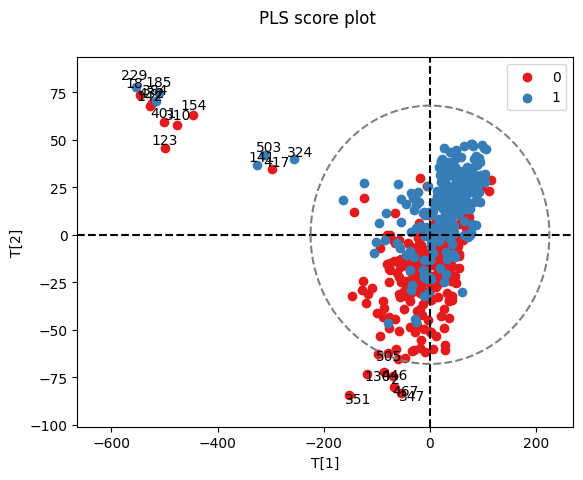

In [15]:
# Plot the scores
pls_da.plot_scores(color=y_train, discrete=True, label_outliers=True, plot_title=None)

It is also possible to assess the overfitting and general model performance by using "machine learning" metrics such as accuracy, precision, recall, f1 score, ROC curves and their respective area under the curve (AUC). These metrics are calculated by comparing the predicted Y values from the model with the true Y values. *It is important to select correct prediction threshold which is by default set to 0.5. This means that all predicted values above the 0.5 threshold will be classified as positive classes (1) and all values below 0.5 will be classified as negative classes (0). We should consider how we want to treat those cases that are very close to the threshold.*
<br>
Below, you can see the confusion matrix for the testing dataset. The confusion matrix is a table with the number of true positives (TP), true negatives (TN), false positives (FP) and false negatives (FN). TP are values correctly predicted as positive, TN are values correctly predicted as negative, FP are values incorrectly predicted as positive and FN are values incorrectly predicted as negative. Using these values, we can calculate the accuracy, precision, recall, specificity and f1 score.

<br>

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

$$Precision = \frac{TP}{TP + FP}$$

$$Recall (Sensitivity) = \frac{TP}{TP + FN}$$

$$Specificity = \frac{TN}{TN + FP}$$

$$F1 = 2 * \frac{Precision * Recall}{Precision + Recall}$$

<br>

AUC is the area under the ROC curve. The ROC curve is a plot of the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The TPR is the same as the recall, and the FPR is 1 - specificity. The AUC is a measure of how well a model can distinguish between classes. An AUC of 1 means the model can perfectly distinguish between classes, and an AUC of 0.5 means the model cannot distinguish between classes at all.
<br>

Note that these metrics assuming that the classes are balanced, this is especially crucial for the accuracy to and AUC. For moderately imbalanced classes use F1 score and  balanced accuracy:

$$Accuracy_{Balanced} = \frac{Specificity + Sensitivity}{2}$$

<br>

For highly imballanced classes, use AUC of Precision--Recal Curve.


In [16]:
# Predict the response Y (sex) based on the test set
y_pred = pls_da.predict(x_test_log)
y_pred

array([0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1])

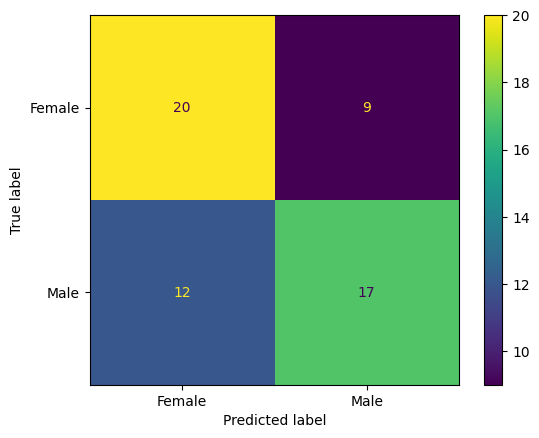

Accuracy 0.638
Precision 0.654
Recall 0.586
Specificity 0.69
F1 Score 0.618
AUC 0.638


In [17]:
# Plot the confusion matrix
# Compare the predicted Y values with the true Y values
cm2 = confusion_matrix(y_test, y_pred )
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=["Female", "Male"])
disp2.plot()
plt.show()

# plot the metrics results
print('Accuracy', round(accuracy_score(y_test,  y_pred ), 3))
print('Precision', round(precision_score(y_test,  y_pred ), 3))
print('Recall', round(recall_score(y_test,  y_pred ), 3))
tn, fp, fn, tp = confusion_matrix(y_test,  y_pred ).ravel()
print('Specificity', round(tn/(tn+fp), 3))
print('F1 Score', round(f1_score(y_test, y_pred ), 3))
print('AUC', round(roc_auc_score(y_test,  y_pred ), 3))

The main directions associated with each component in the score plots can be interpreted in terms of the original X variables using the loading vector, just like in PCA. Each component has an associated loading vector $p$ and weight vector


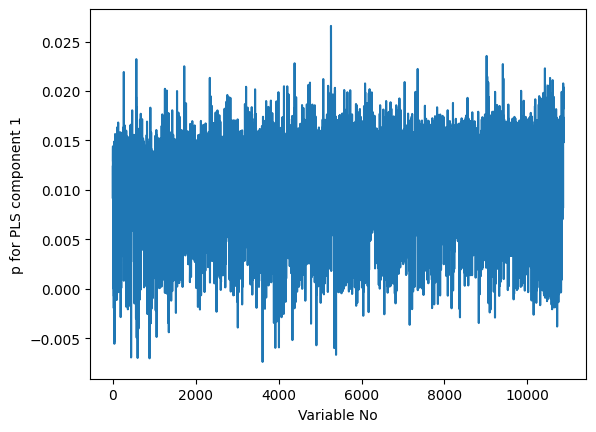

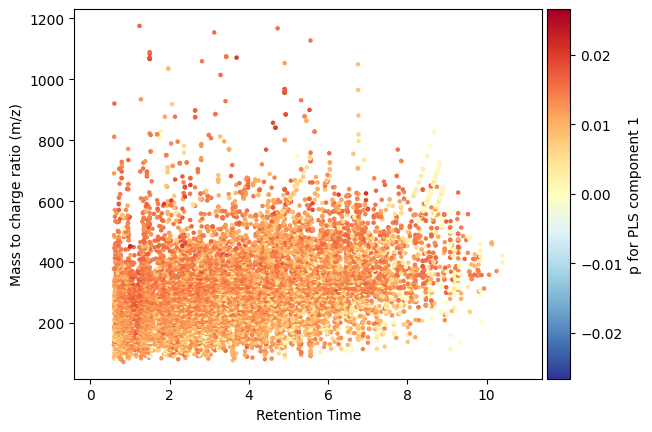

In [18]:
# Plot the weights and loadings.
# w for weights, p for loadings,
# ws for X rotations (rotated version of w)
pls_da.plot_model_parameters(parameter='p', component=1)

# Plot the loadings
pls_da.plot_model_parameters(parameter='p', component=1, instrument = 'lcms', xaxis=retention_times, yaxis=mz_values, marker_size=5, alpha=1)

Besides the loading vectors, PLS models have another important set of parameters, the weight vectors. There is one weight vector ($w$) corresponding to the X matrix and another ($c$) to the Y variables.

The weight vector ($w$) relates the original X variables with the Y outcome we are predicting. These vectors (and metrics based on them, such as VIP) are important to assess the relationship between X and Y and which X variables are more associated with Y. This will be discussed in more detail later in this tutorial.

The larger the magnitude of the variable coefficient in the weight vector, the more "associated" that variable is with the response.

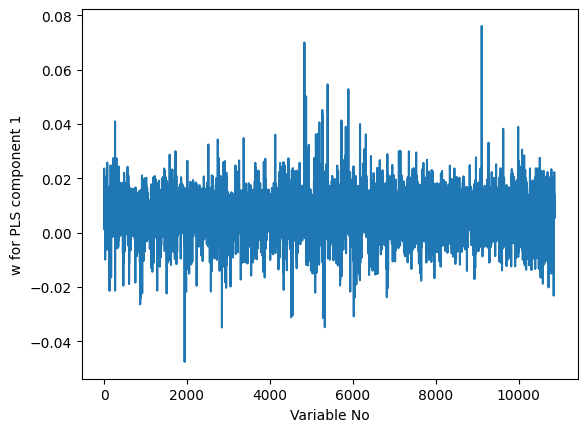

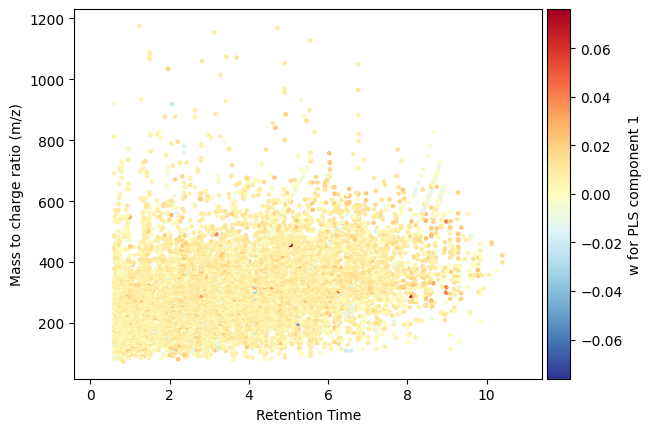

In [19]:
# Plot the weights and loadings.
# w for weights, p for loadings,
# ws for X rotations (rotated version of w)
pls_da.plot_model_parameters(parameter='w', component=1)

pls_da.plot_model_parameters(parameter='w', component=1, instrument = 'lcms', xaxis=retention_times, yaxis=mz_values, marker_size=5, alpha=1)

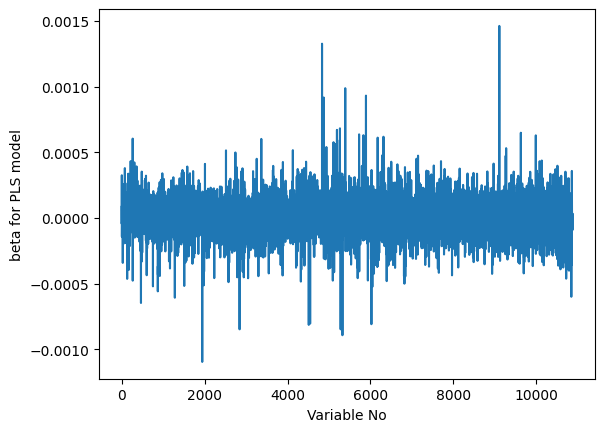

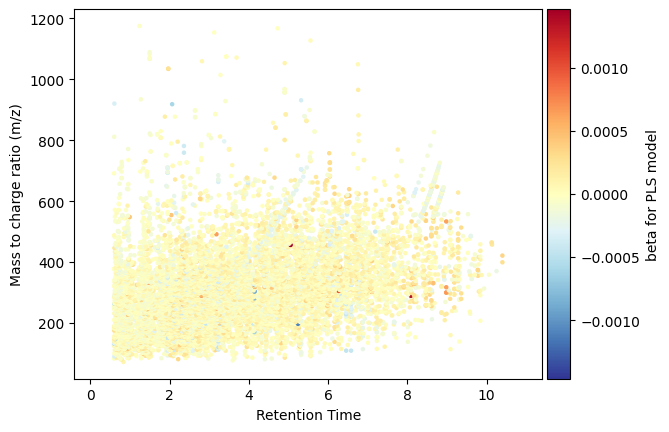

In [20]:
# Plot regression vectors beta
pls_da.plot_model_parameters(parameter='beta', component=1)
pls_da.plot_model_parameters(parameter='beta', instrument = 'lcms', xaxis=retention_times, yaxis=mz_values, marker_size=5, alpha=1)

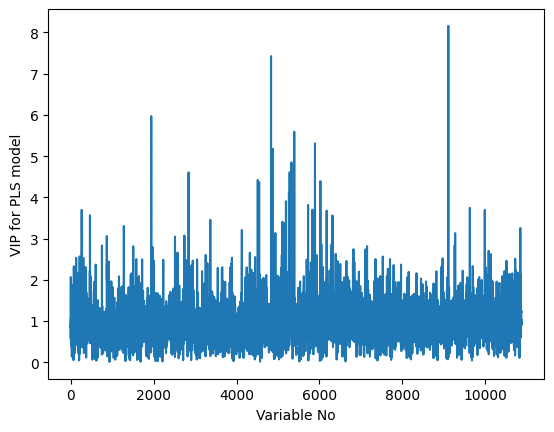

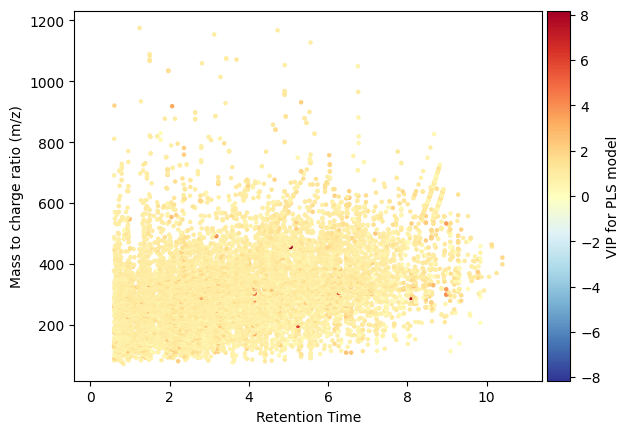

In [21]:

# Plot VIP
pls_da.plot_model_parameters(parameter='VIP', component=1)
pls_da.plot_model_parameters(parameter='VIP', instrument = 'lcms', xaxis=retention_times, yaxis=mz_values, marker_size=5, alpha=1)

## 2) Model Selection
### Latent Variables (components) Estimation

Selection of the number of components for a PLS model follows a very similar logic to the PCA case.
Since the goal is to predict the Y variable, the main criteria used are the $R^{2}Y$/$Q^{2}Y$ as opposed to $R^{2}X$/$Q^{2}X$.

Ideally, we want to select enough components to predict as much of the variation in Y as possible using the data in X, while avoiding overfitting.

We apply a similar criterion as the one used with PCA: choosing as the number of components after which the $Q^{2}Y$ value reaches a plateau (less than 5% increase compared to previous number of components).

In [22]:
pls_da.scree_cv(x_train_log, y_train, total_comps=8)

R2Ymeasure stabilizes (increase of less than 5% of previous value or decrease) at component 6


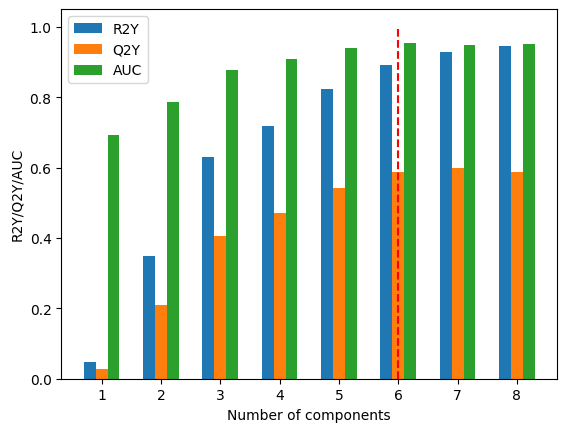

(6, <Axes: xlabel='Number of components', ylabel='R2Y/Q2Y/AUC'>)

In [23]:
pls_da.scree_plot(metric = ['R2Y', 'Q2Y','AUC'])
# Possible metrics (1 to 3 options): 'Q2Y', 'R2Y', 'AUC', 'MCC', 'Recall', 'Precision', 'Precision', 'F1', 'Accuracy'

Just like in the case of PCA, the $Q^{2}Y$ and other validation metrics obtained during K-Fold cross validation is sensitive to row permutation of the X and Y matrices. Shuffling the rows and repeating the cross-validation steps multiple times is a more reliable way to select the number of components.

**Note**: Model cross-validation, especially the *repeated_cv* call in the next cell requires fitting the model multiple times. Do not run in Google Colab as it takes up to 25 minutes.

In [24]:
# Repeated cross_validation - DO NOT RUN IN COLAB
# rep_cv = pls_da.repeated_cv(x_train_log, y_train, repeats=5, total_comps=10)

### Outlier Detection

The outlier detection measures available for PCA (Hotelling $T^{2}$ and DmodX) are also available for PLS/PLS-DA models. Outlier interpretation is also performed in the same way.

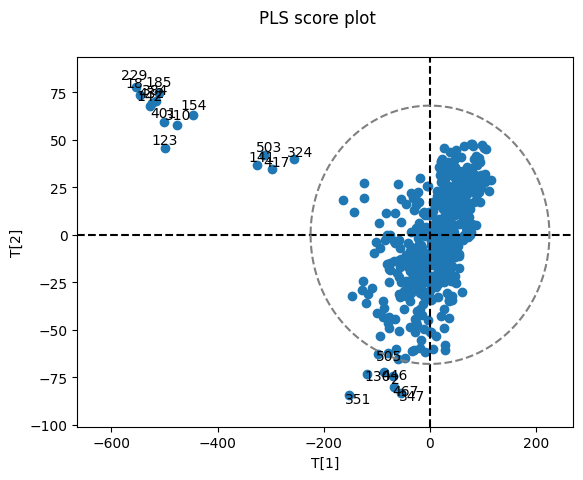

Outliers: [  2  18 123 130 141 142 154 185 229 310 324 347 351 384 401 417 432 446
 467 503 505]


In [24]:
pls_da.plot_scores(label_outliers=True)
pca_outliers = pls_da.outlier(x_train_log)
print('Outliers: {0}'.format(pca_outliers))

The strongest outliers in this case are the 21 samples with more negative PLS component 2 scores. These are actually the same samples identified as outliers during the preliminary PCA analysis. We will remove them before proceeding.

In [25]:
x_no_outliers = np.delete(x_train_log, pca_outliers, axis=0)
y_no_outliers = np.delete(y_train, pca_outliers, axis=0)

We now re-check the optimal number of components after exclusion of outliers.

In [27]:
pls_da.scree_cv(x_no_outliers, y_no_outliers, total_comps=8)

R2Ymeasure stabilizes (increase of less than 5% of previous value or decrease) at component 6


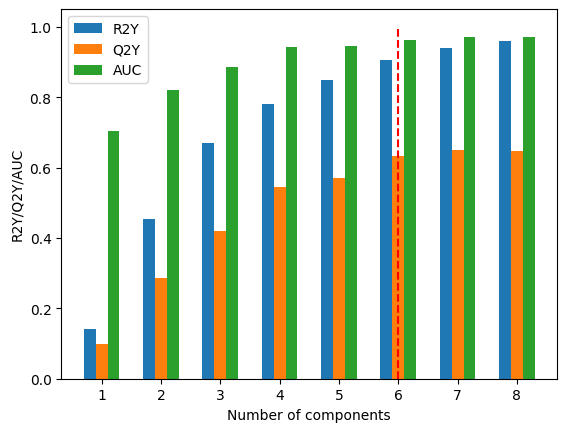

(6, <Axes: xlabel='Number of components', ylabel='R2Y/Q2Y/AUC'>)

In [28]:
pls_da.scree_plot(metric = ['R2Y', 'Q2Y','AUC'])

In [ ]:
# # Repeated cross_validation - DO NOT RUN IN COLAB
# rep_cv = pls_da.repeated_cv(x_no_outliers, y_no_outliers, repeats=6, total_comps=10)

Following the recommendations from cross-validation and repeated cross validation we select 6 as the final number of components.

### Refit the Model
Refit the model without outliers and use the number of components selected.

In [29]:
# Refit the model with the selected number of components
pls_da = ChemometricsPLSDA(n_components=6, x_scaler=scaling_object_mc)
pls_da.fit(x_no_outliers, y_no_outliers)

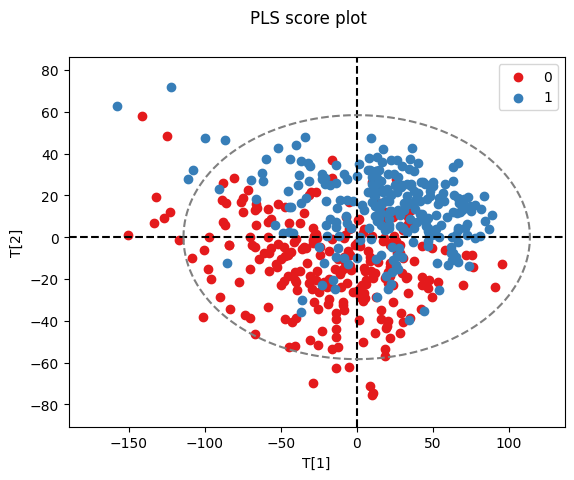

In [30]:
pls_da.plot_scores(color=y_no_outliers, discrete=True)

### Final-Model Evaluation

Although we used the $Q^{2}Y$ metric to perform model selection, this metric is easier to interpret for regression problems, and it is not straightforward to assess the performance of a classifier model using $Q^{2}Y$ or $R^{2}Y$ and similar goodness of fit metrics. The performance in a classification task is more effectively described by confusion matrices and related metrics, such as accuracy/balanced accuracy, f1, ROC curves and their respective area under the curve.

To obtain more reliable estimates we can calculate the cross-validation estimates of any of these metrics, including cross-validated ROC curves. This ROC curve was estimated using the left-out samples (the test sets) during cross-validation.

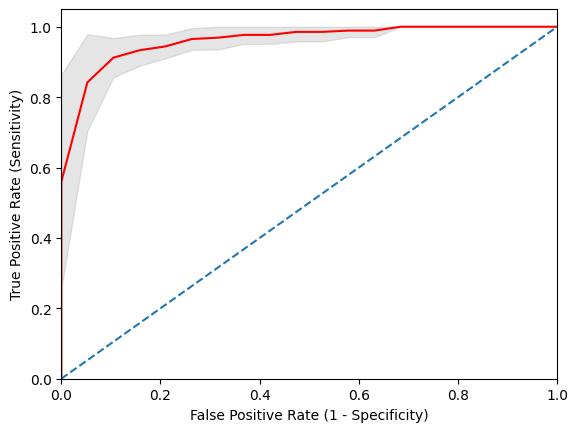

Mean AUC: [0.96038591]


In [31]:
# Cross-validated ROC curve
pls_da.cross_validation(x_no_outliers, y_no_outliers)
pls_da.plot_cv_ROC()

Now we can assess the model performance using test set samples which were not used during model fitting or cross-validation. Compare the confusion matrices and classification metrics of the model fitted with 2 latent variables and the model fitted with 4 latent variables.

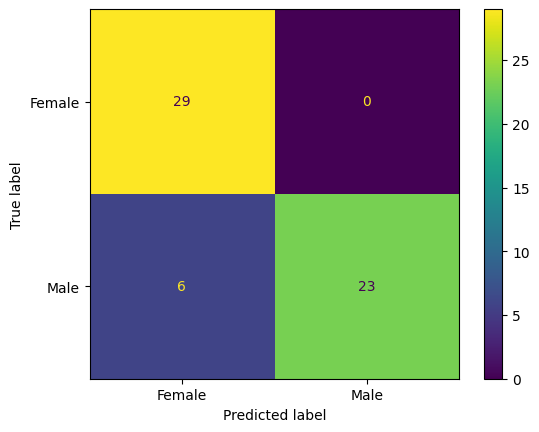

Accuracy 0.897
Precision 1.0
Recall 0.793
Specificity 1.0
F1 Score 0.885
AUC 0.897


In [33]:
# Predict the response Y (sex) based on the test set
y_pred = pls_da.predict(x_test_log)

# Plot the confusion matrix
# Compare the predicted Y values with the true Y values
cm2 = confusion_matrix(y_test,  y_pred )
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=["Female", "Male"])
disp2.plot()
plt.show()

# plot the metrics results
print('Accuracy', round(accuracy_score(y_test,  y_pred ), 3))
print('Precision', round(precision_score(y_test,  y_pred ), 3))
print('Recall', round(recall_score(y_test,  y_pred ), 3))
tn, fp, fn, tp = confusion_matrix(y_test,  y_pred ).ravel()
print('Specificity', round(tn/(tn+fp), 3))
print('F1 Score', round(f1_score(y_test,  y_pred ), 3))
print('AUC', round(roc_auc_score(y_test,  y_pred ), 3))

### Permutation Testing

A final and very important method for model validation is the permutation randomization test. In a permutation randomisation test, the model will be refitted and assessed multiple times, but each time with the Y randomly permuted to destroy any relationship between X & Y. This allows us to assess what sort of model we can get when there really is no relationship between the two data matrices, and calculate the likelihood of obtaining a model with predictive performance as good as the non-permuted model by chance alone.

During this test, the number of components, scaling, type of cross-validation employed, and any other modeling choice is kept constant. In each randomization, the model is refitted, and the AUC, $Q^{2}Y$ or any other validation metric is recorded. This enables the generation of permuted null distributions for any parameter, which can be used to obtain an empirical *p-value* for their significance.

**Note** Running the permutation test with a large number of permutation randomisations (for example, 1000) is expected to take a considerable amount of time (approximately 70 minutes on a laptop).

In [ ]:
# permt = pls_da.permutation_test(x_no_outliers, y_no_outliers, 1000)
# np.save('./data/permutations_plsda.npy', permt)

You can load pre-executed permutation test from here:

In [34]:
# Load from Google Drive using bash command

import gdown
file_id = "1hYBsVXZotFHC3VLkH2GWacvUlcmBeaQP"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "permutations_plsda.npy", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1hYBsVXZotFHC3VLkH2GWacvUlcmBeaQP
From (redirected): https://drive.google.com/uc?id=1hYBsVXZotFHC3VLkH2GWacvUlcmBeaQP&confirm=t&uuid=f2e587ce-e79e-408a-af2c-a6fdd568cd8a
To: /content/IPTC-chemometrics-tutorials-LCMS/permutations_plsda.npy
100%|██████████| 1.74G/1.74G [00:22<00:00, 76.5MB/s]


'permutations_plsda.npy'

In [35]:
permt = np.load('permutations_plsda.npy', allow_pickle=True)

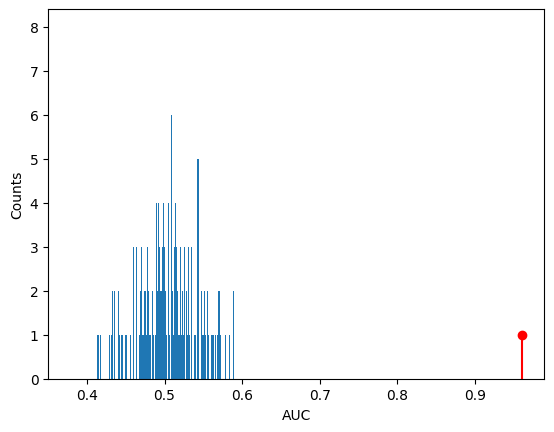

Permutation p-value for the AUC: 0.000999000999000999


In [36]:
# plot the results from the permuation test
pls_da.plot_permutation_test(permt, metric='AUC')
print("Permutation p-value for the AUC: {0}".format(permt[1]['AUC']))

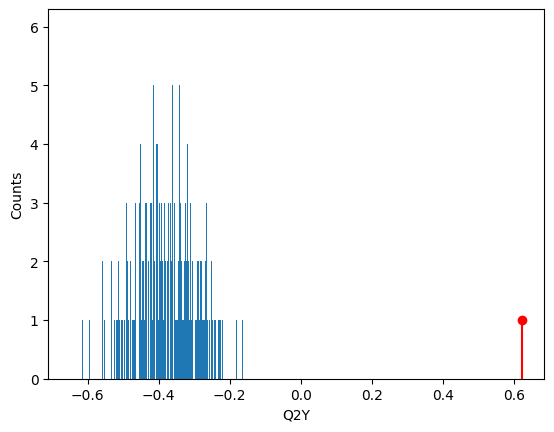

Permutation p-value for the Q2Y: 0.000999000999000999


In [37]:
# plot the results from the permuation test
pls_da.plot_permutation_test(permt, metric='Q2Y')
print("Permutation p-value for the Q2Y: {0}".format(permt[1]['Q2Y']))

The *p-value* obtained is < 0.05, so the model AUC and Q2Y values are significantly different from what is expected by chance alone at a level of $\alpha$ = 0.05.

## 3) Model interpretation and variable importance

The main parameters to assess in terms of variable importance for the prediction of Y from X are the weights ($w$), the VIP metric and regression coefficients.

The values in a weight vector vary between -1 (strong negative-covariance) and 1 (strong covariance), with 0 meaning no association/covariance. The weight vector of the first component (which explains the most variation in Y) is the primary weight vector to analyze when interpreting the main variables of X associed with Y.

The variable importance for prediction (VIP) metric is a sum (weighted by the ammount of variance of Y explained by each respective component) of the squared weight values. It provides a summary of the importance of a variable accounting for all weight vectors. VIPs are bounded between 0 (no effect) and infinity. Because it is calculated from the weights $w$, for PLS models with a single component these are directly proportional to the $w^{2}$. The VIP metric has the disadvantage of pooling together $w$ vectors from components which contribute a very small magnitude to the model's $R^{2}Y$.

The regression coefficients ($\beta$) have a similar interpretation as regression coefficients in a multivariate/multiple linear regression.

Number of selected variables: 746


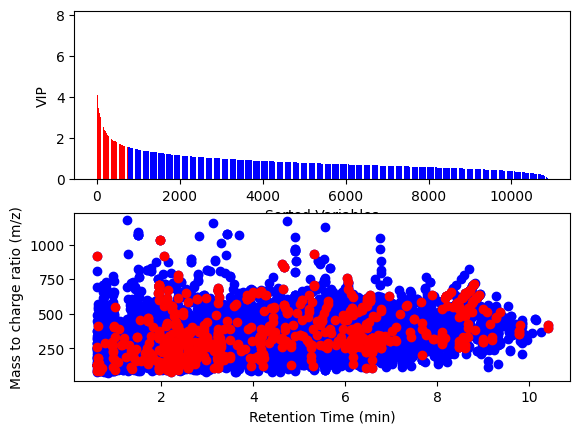

In [38]:
pls_da.VIP_variableselection(x_no_outliers, threshold='knee', instrument='lcms',
                                     xaxis=retention_times, yaxis=mz_values)

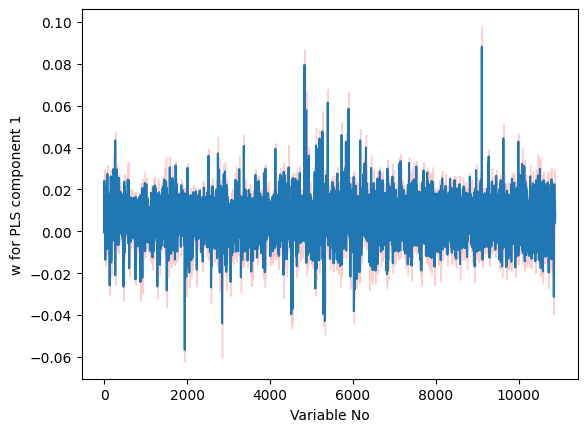

In [39]:
pls_da.plot_model_parameters('w', component=1, sigma=2, cross_val=True)



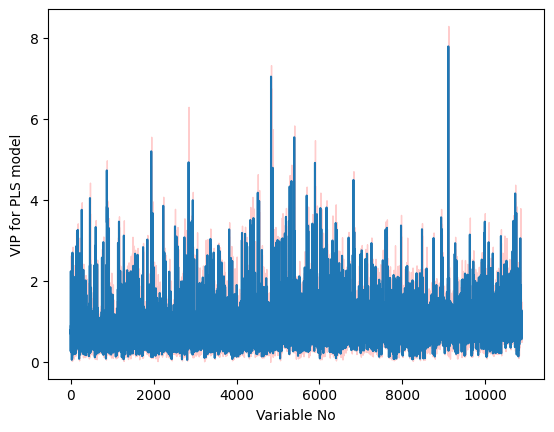

In [40]:
pls_da.plot_model_parameters('VIP', sigma=2, cross_val=True)

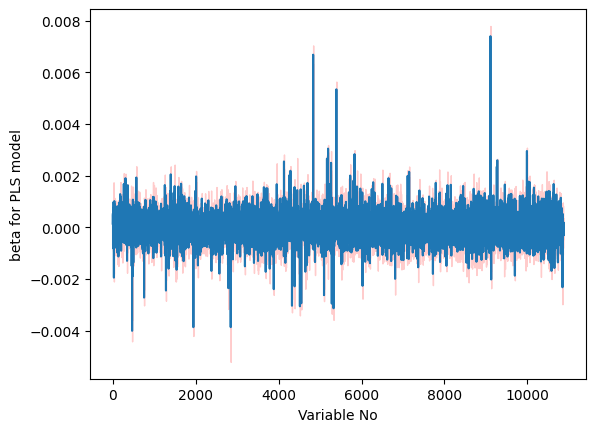

In [41]:
pls_da.plot_model_parameters('beta', sigma=2, cross_val=True)


Unfortunately, assessment of variable importance in PLS-DA/PLS multivariate models is not straightfoward, given the multiple choice of parameters and their different interpretation, especially in models with more than 1 PLS component. To obtain a ranking of variables from the data matrix X associated with Y, we recommend starting with the weights $w$ of the first component, which contributes the most to $R^{2}Y$.

However, it must be mentioned that the weights of the first PLS component are equal to the normalized (so that the weight vector has norm equal to 1) vector of the univariate covariances estimated between each X column or variable, and the Y vector. This implies there is no advantage in using a PLS model and $w$ when compared to a series of univariate analyses for variable ranking and selection.

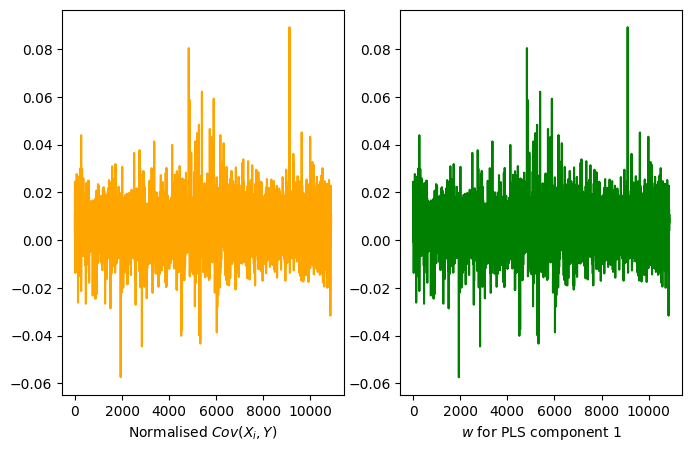

In [42]:
fig, ax = plt.subplots(1,2, figsize=(8, 5))
X_scaled = pls_da.x_scaler.transform(x_no_outliers)

cov_x_y = np.dot(y_no_outliers.T - y_no_outliers.mean(), X_scaled) / (y_no_outliers.shape[0]-1)
cov_x_y = cov_x_y/np.linalg.norm(cov_x_y)

ax[0].plot(cov_x_y, 'orange')
ax[1].plot(pls_da.weights_w[:, 0], 'green')
ax[0].set_xlabel('Normalised $Cov(X_{i}, Y)$')
ax[1].set_xlabel('$w$ for PLS component 1')
fig.show()

Another set of quantities which can be used to assess variable importance are the $\beta$ regression coefficients. However, as with other multivariate regression models, the final $\beta$ vector encodes information about the correlation structure of X and how it relates to Y, and the magnitude and sign of $\beta$ coefficient express how to derive a "good" prediction of Y using X. Taking the magnitude of each $\beta$ and using it to rank variables can be misleading.

This does not mean necessarily that PLS should only be used as a predictive "black box" regressor/classifier and model interpretation avoided altogether. The strength of PLS for exploratory data analysis and interpretation resides on the latent variable projections. The scores $T$ or $U$ can be plotted and associated with other metadata variables, or even correlated or regressed against them, and the corresponding loading $p$ can be visualized to assess the signals which make up the latent variable signature.

For example, if we inspect the scores plot for components 2 and 3 it becomes apparent that although we have not added information about the Age covariate to the model, the PLS component number 3 seems to be associated with it. This hints that this component is accounting for some of the variability related with Age to improve the prediction. The loadings of this component can then be used to visualize which regions of the spectrum are correlated.

**Note**: We recommend refering to loadings $p$ and not weights $w$ when interpreting latent variable signatures, especially in PLS components after the 1st component.


### Permutation p-values for variable ranking

The permutation test we ran before is also useful to obtain permuted null distributions for most of the model parameters. These can be used to obtain empirical confidence intervals and potentially permutation *p-values* for hypothesis testing.

To illustrate this, the next cells generate histograms for the permuted distribution of the $w$ and $p$ for the first PLS component and regression coefficients for 2 randomly selected variables. Then we will visualise the same values for the observed (real) model using a red dashed line.

Notice the differences between the permuted null distributions of weights, loadings and regression coefficients.

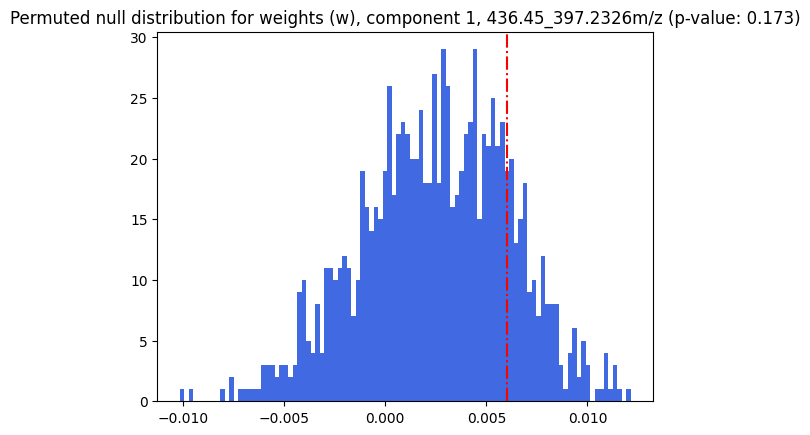

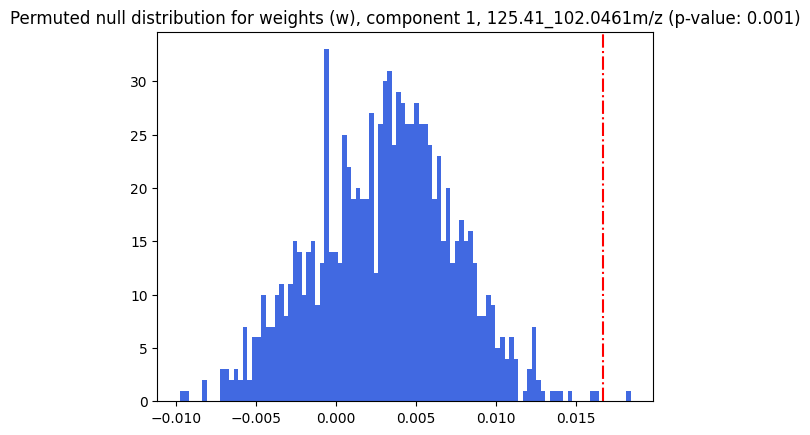

In [43]:
# Plot empirical null distributions for weights
plt.figure()
plt.hist(permt[0]['Weights_w'][:, 8008, 0], 100, color='royalblue')
pvalue = np.sum(permt[0]['Weights_w'][:, 8008, 0] > pls_da.weights_w[ 8008, 0])/1001
plt.title(f"Permuted null distribution for weights (w), component 1, {variable_names[8008]} (p-value: {pvalue:.3f})")
plt.axvline(pls_da.weights_w[ 8008, 0], color='red', linestyle='-.')
plt.show()


plt.figure()
plt.hist(permt[0]['Weights_w'][:, 96, 0], 100, color='royalblue')
pvalue = np.sum(permt[0]['Weights_w'][:, 96, 0] > pls_da.weights_w[ 96, 0])/1001
plt.title(f"Permuted null distribution for weights (w), component 1, {variable_names[96]} (p-value: {pvalue:.3f})")
plt.axvline(pls_da.weights_w[ 96, 0], color='red', linestyle='-.')
plt.show()

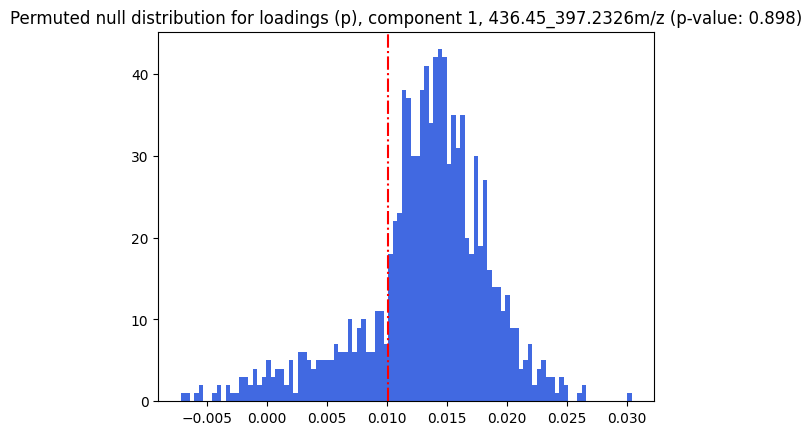

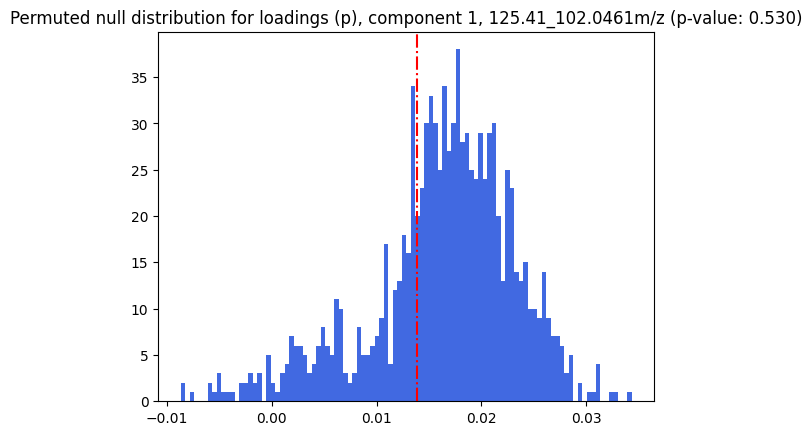

In [44]:
# Plot empirical null distributions for loadings
# Notice how these are not unimodal and distributed around 0...
plt.figure()
plt.hist(permt[0]['Loadings_p'][:, 8008, 0], 100, color='royalblue')
pvalue = np.sum(permt[0]['Loadings_p'][:, 8008, 0] > pls_da.weights_w[ 8008, 0])/1001
plt.title(f"Permuted null distribution for loadings (p), component 1, {variable_names[8008]} (p-value: {pvalue:.3f})")
plt.axvline(pls_da.loadings_p[ 8008, 0], color='red', linestyle='-.')
plt.show()

plt.figure()
plt.hist(permt[0]['Loadings_p'][:, 96, 0], 100, color='royalblue')
pvalue = np.sum(permt[0]['Loadings_p'][:, 96, 0] > pls_da.weights_w[ 96, 0])/1001
plt.title(f"Permuted null distribution for loadings (p), component 1, {variable_names[96]} (p-value: {pvalue:.3f})")
plt.axvline(pls_da.loadings_p[ 96, 0], color='red', linestyle='-.')
plt.show()

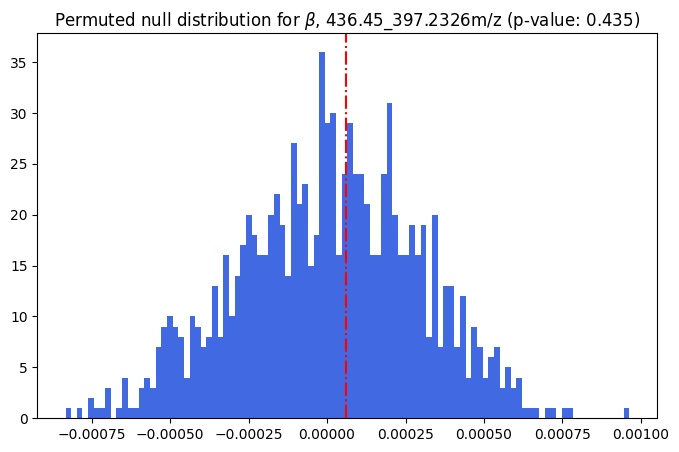

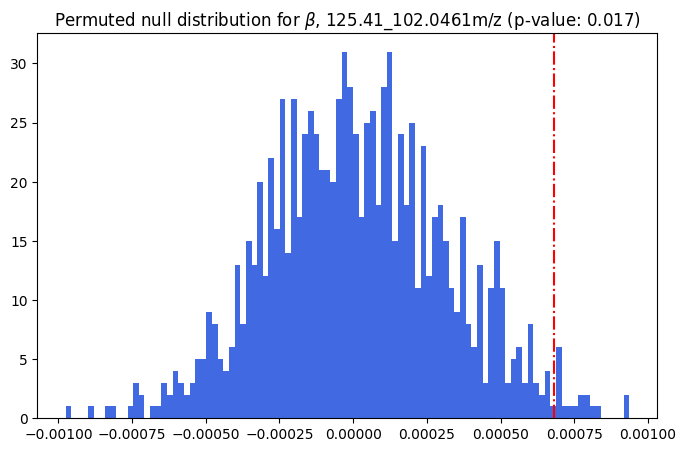

In [45]:
plt.figure(figsize=[8,5])
plt.hist(permt[0]["Beta"][:, 8008], 100, color='royalblue')
pvalue = np.sum(permt[0]['Beta'][:, 8008] > pls_da.beta_coeffs[0][ 8008])/1001
plt.title(rf"Permuted null distribution for $\beta$, {variable_names[8008]} (p-value: {pvalue:.3f})")
plt.axvline(pls_da.beta_coeffs[0][ 8008], color='red', linestyle='-.')
plt.show()

plt.figure(figsize=[8,5])
plt.hist(permt[0]['Beta'][:, 96], 100, color='royalblue')
pvalue = np.sum(permt[0]['Beta'][:, 96] > pls_da.beta_coeffs[0][96])/1001
plt.title(rf"Permuted null distribution for $\beta$, {variable_names[96]} (p-value: {pvalue:.3f})")
plt.axvline(pls_da.beta_coeffs[0][96], color='red', linestyle='-.')
plt.show()

Both the regression coefficients and weights have a null distribution centered around 0. Conversely, for the loadings, the center of the distribution is shifted. Loadings encode information about the variance and covariance (with the latent variable score) of each variable, and their magnitude is harder to interpret in terms of importance for prediction. The permutation performed in this manner does not change the correlation between variables in X, and therefore is not adequate to obtain permuted null distributions of the loading parameters.

We can now calculate empirical p-values for the regression coefficients...

In [46]:
# Always set *nperms* equal to the number of permutations used before
nperms = permt[0]['R2Y'].size
perm_indx = abs(permt[0]['Beta'].squeeze()) >= abs(pls_da.beta_coeffs.squeeze())
counts = np.sum(perm_indx, axis=0)
beta_pvals = (counts + 1) / (nperms + 1)

perm_indx_W = abs(permt[0]['Weights_w'][:, :, 0].squeeze()) >= abs(pls_da.weights_w[:, 0].squeeze())
counts = np.sum(perm_indx_W, axis=0)
w_pvals = (counts + 1) / (nperms + 1)

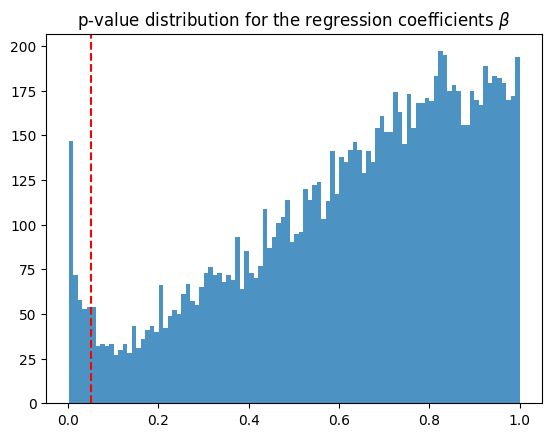

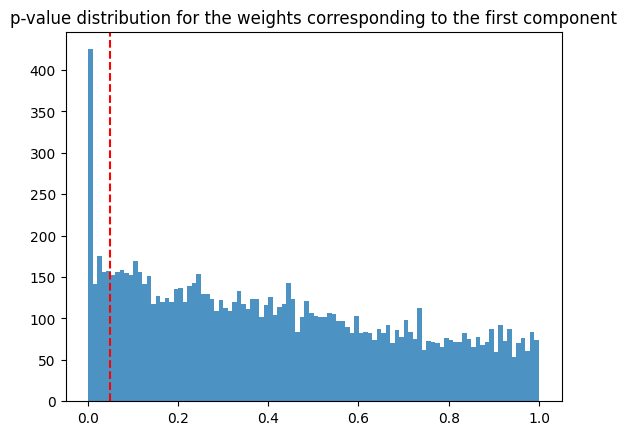

In [47]:
plt.figure()
plt.title(r"p-value distribution for the regression coefficients $\beta$ ")
z = plt.hist(beta_pvals, bins=100, alpha=0.8)
plt.axvline(x=0.05, ymin=0, ymax=max(z[0]), color='r', linestyle='--')
plt.show()

plt.figure()
plt.title(r"p-value distribution for the weights corresponding to the first component")
z = plt.hist(w_pvals, bins=100, alpha=0.8)
plt.axvline(x=0.05, ymin=0, ymax=max(z[0]), color='r', linestyle='--')
plt.show()

... and use the permutation test to obtain a list of statistically significant variables.

In [48]:
signif_bpls_idx = np.where(beta_pvals <= 0.05)[0]

print("Number of significant values: {0}".format(len(signif_bpls_idx)))

Number of significant values: 384


In [49]:
# Which are the significant predictors
np.where(beta_pvals <= 0.05)

(array([   26,    37,    96,   138,   156,   177,   200,   228,   236,
          237,   239,   248,   257,   261,   277,   305,   353,   354,
          358,   393,   397,   414,   432,   454,   462,   464,   465,
          477,   495,   527,   546,   552,   565,   592,   613,   641,
          680,   688,   698,   720,   736,   754,   760,   764,   783,
          784,   785,   973,  1006,  1024,  1038,  1044,  1049,  1053,
         1142,  1163,  1174,  1183,  1282,  1285,  1324,  1328,  1335,
         1374,  1377,  1387,  1401,  1411,  1427,  1450,  1539,  1563,
         1582,  1598,  1604,  1635,  1647,  1679,  1707,  1710,  1736,
         1752,  1788,  1812,  1826,  1882,  1943,  1986,  1995,  1999,
         2009,  2029,  2041,  2089,  2092,  2119,  2144,  2193,  2219,
         2267,  2284,  2295,  2304,  2309,  2345,  2370,  2376,  2490,
         2494,  2509,  2560,  2570,  2586,  2596,  2646,  2770,  2840,
         2869,  2874,  2877,  2905,  2926,  2946,  2956,  3010,  3019,
      

It is worth noting that a selection procedure of this kind is also a type of multiple testing, and it is recommended to apply false discovery rate or any other multiple testing correction to the *p-values* obtained in this manner. Also, formal inferential procedures to derive *p-values* and confidence intervals are not established for PLS models. Although *ad-hoc* solutions like a permutation test can be implemented as shown, some issues still remain - for example, the *p-value* distribution obtained for the regression coefficients is clearly non-uniform and care must be exercised when performing multiple testing correction or even interpreting the *p-values* obtained in this manner.

The latent variable and dimensionality reduction provided by PLS/PLS-DA can be very usefull to visualize general trends in the data. However, interpreting which variables are important to the model and how they contribute for the explanation/separation between classes is not easy. We suggest complementing the inspection of multivariate model parameters with univariate analysis.

## 4) A Brief Introduction to OPLS

The orthogonal PLS modeling technique can be used to assist interpretation of PLS latent variables.
After obtaining a reliable PLS model, we generate an Orthogonal PLS/PLS-DA model with the same number of components as the PLS model. In an orthogonal PLS model, the first component is called predictive, and the subsequent components "orthogonal" because they are uncorrelated to the response Y. Compared to the equivalent PLS model, Orthogonal PLS models shuffle away variation from the loading vector $p$ of the first component to subsequent components, which can aid in interpretation of the latent variables.

In [50]:
# Generate an Orthogonal PLS-DA version of the PLS-DA model fitted
orthogonal_pls_da = ChemometricsOrthogonalPLSDA( x_scaler=scaling_object_mc, n_components=6)
orthogonal_pls_da.fit(x_no_outliers, y_no_outliers)

The Orthogonal PLS model we just fitted has 1 predictive component and 4 orthogonal components. The predictive component encodes the information in X directly associated with Y.
The orthogonal components can be investigated and associated with other known covariates, to assist in understanding the sources of variation that the PLS model/Orthogonal PLS model is "learning" from the data to improve the prediction of Y (measured by the $R^{2}Y$)

In the following plot, we investigate the scores on the predictive ($T_{pred}$) and first orthogonal component ($T_{ortho[1]}$), coloured by sex.

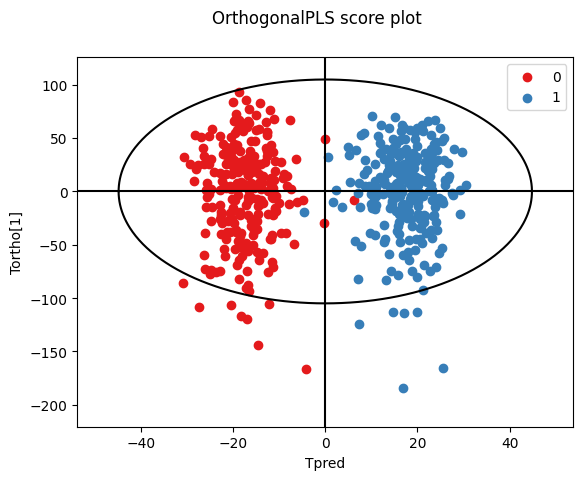

In [51]:
orthogonal_pls_da.plot_scores(color=y_no_outliers, orthogonal_component=1, discrete=True)

### Orthogonal PLS model evaluation
The interpretation of the Orthogonal PLS score plorts model should be made using the predictive and orthogonal loading vectors ($p$) for all components. Only the weight vector $w$ for the predictive component should be evaluated


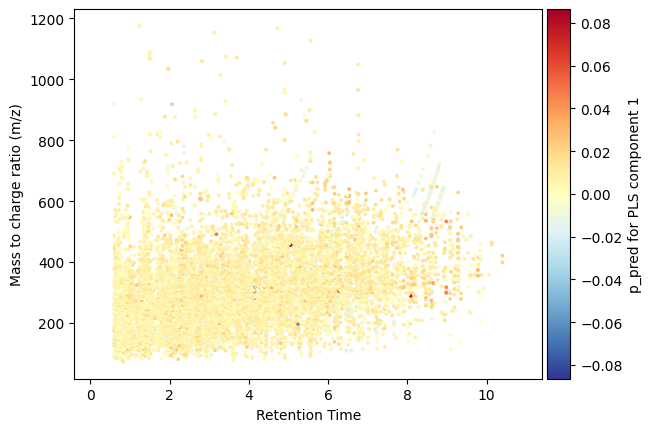

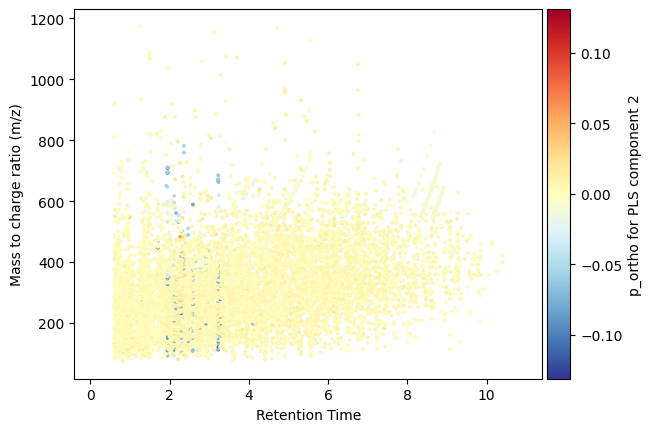

In [52]:
# Plot the weights and loadings - The updated version
orthogonal_pls_da.plot_model_parameters('p_pred', orthogonal_component = 1, instrument = 'lcms', xaxis=retention_times, yaxis=mz_values, alpha=1)

orthogonal_pls_da.plot_model_parameters('p_ortho', orthogonal_component = 2, instrument = 'lcms', xaxis=retention_times, yaxis=mz_values, alpha=1)

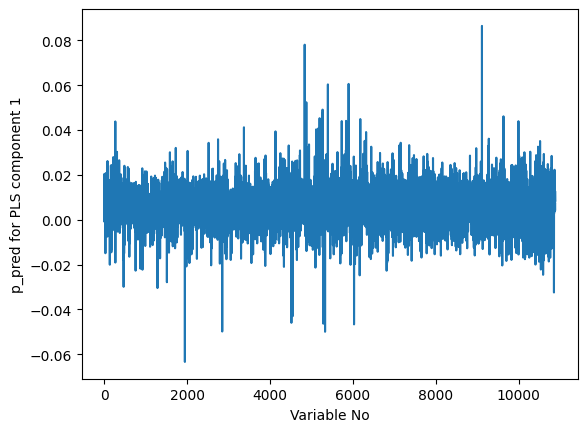

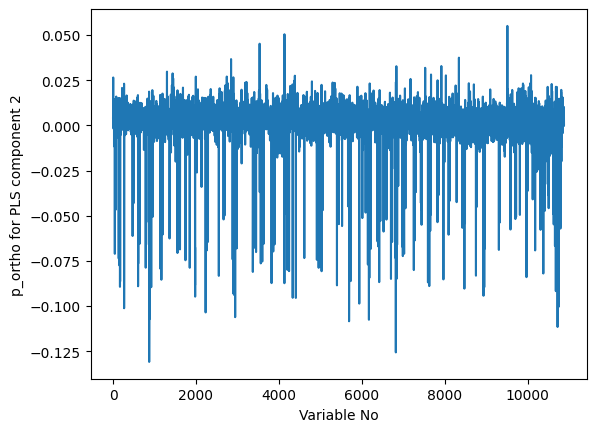

In [53]:
orthogonal_pls_da.plot_model_parameters('p_pred', orthogonal_component = 1)

orthogonal_pls_da.plot_model_parameters('p_ortho', orthogonal_component = 2)